In [1]:
from wtlike import Config, Simulation, WtLike
import numpy as np

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

Either run this [notebook](https://github.com/tburnett/wtlike/blob/master/nbs/99_tutorial.ipynb), or copy the cells into a new notebook.

`wtlike` is on PyPI--to install it,

```
pip install wtlike
```
Next we generate a simulated on-the-fly dataset in lieu of downloading the 3-GB of so of the *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [2]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- effective area -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin all the photons into daily time-bins, called "cells". (The time binning can be easily redone.)

In [3]:
config=Config()
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, config=config, time_bins=(0,0,1))

generated 18664 photons
SourceData: Source flare_sim with:
	 data:        18,664 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average effective area 3000 cm^2 for 2.6 Ms
	 rates:  source 1.42e-06/s, background 9.82e-07/s,
CellData.rebin: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>5 & n>2


Now make a light curve!

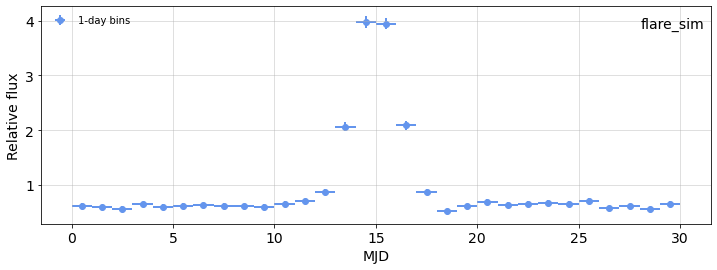

In [4]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [5]:
daily.cells.head(2)

,t,tw,e,n,w,S,B
0,0.5,1.0,258.299988,540,"[0.88695556, 0.6516491, 0.40397277, 0.00549019...",366.216003,253.757095
1,1.5,1.0,259.200012,483,"[0.5980684, 0.7125182, 0.0100688925, 0.8557029...",367.492065,254.641296


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [6]:
daily.fluxes.head(2)

,t,tw,n,e,ts,flux,errors,limit
0,0.5,1.0,540,258.299988,381.4,0.6155,"(-0.048, 0.05)",0.699286
1,1.5,1.0,483,259.200012,354.6,0.5929,"(-0.047, 0.049)",0.675680


#### About DataFrames
The properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) objects.
For those unfamiliar with pandas, note that one can create "csv" files with the method `to_csv(`*filename*`)`.

The function `query` is very useful: To select the cells with flux>3,

In [7]:
daily.fluxes.query('flux>3')

,t,tw,n,e,ts,flux,errors,limit
14,14.5,1.0,1626,259.200012,9822.7,3.9780,"(-0.105, 0.107)",4.156525
15,15.5,1.0,1603,259.200012,9716.3,3.9478,"(-0.105, 0.107)",4.125787


## Views
A `WtLike` object provides a function `view`, which returns a copy but with a different binning. 
So if we want a detailed look at the flare, we can choose an interval. The parameters specify an interval 10 days after the start, and 10 days before the end, with 1/day or 6-hour bins.

CellData.rebin: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>1.25 & n>2


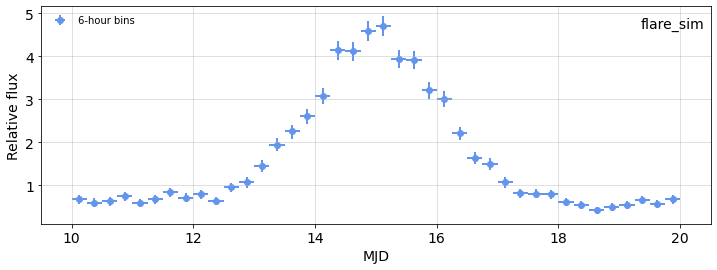

In [8]:
qday = daily.view(10, -10, 0.25)
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

Bayesian Blocks: partitioning 40 cells using LikelihoodFitness with penalty 5%
	found 10 / 40 blocks.
LightCurve: Loaded 10 / 10 cells for fitting


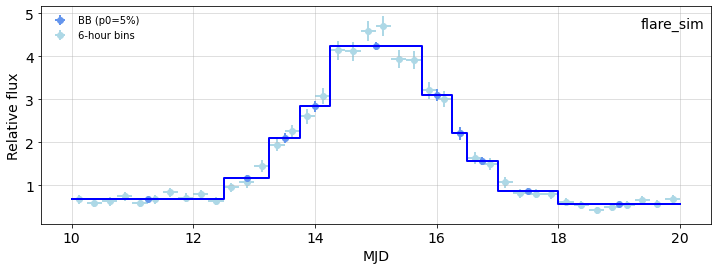

In [9]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [10]:
bb.fluxes

,t,tw,n,e,ts,flux,errors,limit
0,11.250,2.50,1354,64.800000,1126.1,0.6853,"(-0.032, 0.032)",0.739687
1,12.875,0.75,514,64.800003,929.8,1.1579,"(-0.07, 0.072)",1.279529
2,13.500,0.50,478,64.800003,1726.1,2.0977,"(-0.11, 0.113)",2.289207
3,14.000,0.50,605,64.800003,2904.3,2.8378,"(-0.126, 0.13)",3.056549
4,15.000,1.50,2568,64.799998,16163.5,4.2359,"(-0.089, 0.09)",4.385392
5,16.000,0.50,669,64.800003,3271.1,3.1061,"(-0.132, 0.136)",3.334687
6,16.375,0.25,249,64.800003,913.2,2.2067,"(-0.159, 0.165)",2.489491
7,16.750,0.50,399,64.800003,1043.6,1.5641,"(-0.097, 0.1)",1.733543
8,17.500,1.00,594,64.800003,745.8,0.8717,"(-0.054, 0.056)",0.965596
9,19.000,2.00,1025,64.800003,637.3,0.5628,"(-0.033, 0.034)",0.619901


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [11]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
    debug=False,
    rng=None,
    config=None,
)
Docstring:     
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar | function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : the width of the PSF in (r/rmax)**2 coordinates
- rng : random generator instance, or integer seed
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [12]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells
    creates copies with new cells:
      - view
      - phase_view

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -

The three WtLike methods have (preliminary) help as well:

In [13]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specified, will use '.' if many bin

In [14]:
WtLike.view?

Signature: WtLike.view(self, *pars, exp_min=None, no_update=False)
Docstring:
Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.

- no_update -- avoid fitting the cells if invoked by LightCurve or WtLike
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from the above code is that one substitues `PointSource` with the designation of a source, for `Simulation`. 

Also, the data files must be available, the config parameter `datapath` set to the relevant folder. 
Currently it is set by a line in `~/.config/wtlike/config.yaml`.  See the [Config help](https://tburnett.github.io/wtlike/config#Config).

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.

All are available in a 2-GB zip file.

The photon and spacecraft data can be checked with `check_data`

The configuration must be valid, with path to data existing

In [15]:
from wtlike import *
config = Config()
if config.valid:
    #print(check_data())
    source = PointSource('3C 279'); 
    print(source)
    wtl = WtLike(source, exp_min=50)

Source "3C 279" at: (l,b)=(305.104,57.062), nickname P88Y3243
SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       191,313 photons from 2008-08-04 to 2022-05-26
	 exposure: 3,042,347 intervals,  average effective area 2768 cm^2 for 90.8 Ms
	 rates:  source 4.03e-07/s, background 3.58e-07/s, TS 182134.1
CellData.rebin: Bin photon data into 720 1-week bins from 54683.0 to 59723.0
LightCurve: select 309 cells for fitting with e>350 & n>2


If the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

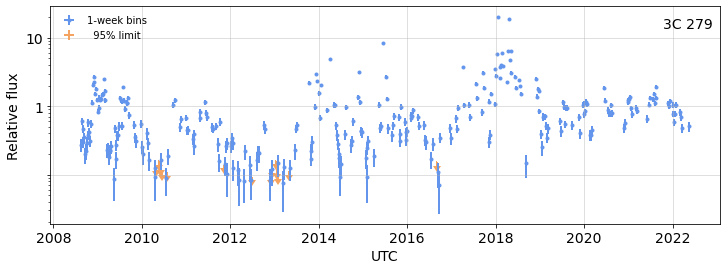

In [16]:
if config.valid: wtl.plot(log=True, UTC=True);